In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [38]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
parent_parent_dir = os.path.dirname(parent_dir)

if parent_parent_dir not in sys.path:
    sys.path.append(parent_parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [39]:
# 读取数据
sheet = pd.read_excel('data_input/日均铁水产量.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
sheet.index.freq = None
last_day = sheet['日均铁水产量'].last_valid_index()
sheet.columns 

Index(['日均铁水产量', '日均铁水产量模拟值(预测/装置跟踪)', '螺纹高炉利润/上海/即期', '热卷高炉利润/上海/即期',
       '247家钢铁企业盈利率', '热卷厂内/社会库存比值', '螺纹盘面利润', '铁矿钢厂库存Trend/F0.1', '铁矿基差率',
       '焦炭基差率', '五大钢材周度表需(预测/3年季节性/20期)'],
      dtype='object')

In [40]:
# 获取last_day之后的数据
future_data_30days = sheet[sheet.index > last_day]
# 计算需要的31个工作日
target_days = pd.date_range(start=last_day + pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]

if len(future_data_30days) == 0:
    new_index = pd.date_range(start=last_day + pd.DateOffset(1), end=target_end, freq='B')
    sheet = sheet.reindex(sheet.index.union(new_index))

elif future_data_30days.index.max() > target_end:
    sheet = sheet[sheet.index <= target_end]
    new_index = pd.date_range(start=last_day + pd.DateOffset(1), end=target_end, freq='B')
    sheet = sheet.reindex(sheet.index.union(new_index))

else:
    max_future_date = future_data_30days.index.max() if len(future_data_30days) > 0 else last_day
    new_index = pd.date_range(start=max_future_date + pd.DateOffset(1), end=target_end, freq='B')
    sheet = sheet.reindex(sheet.index.union(new_index))

sheet = sheet.sort_index()

# 填充缺失值
fill_methods = {
    '日均铁水产量模拟值(预测/装置跟踪)': 'interpolate',
    '螺纹高炉利润/上海/即期': 'interpolate',
    '热卷高炉利润/上海/即期': 'interpolate',
    '247家钢铁企业盈利率':'interpolate',
    '热卷厂内/社会库存比值':'interpolate',
    '螺纹盘面利润':'interpolate',
    '铁矿钢厂库存Trend/F0.1':'interpolate',
    '铁矿基差率':'interpolate',
    '焦炭基差率':'interpolate',
    '五大钢材周度表需(预测/3年季节性/20期)':'interpolate'
} 
sheet = fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet.loc[:last_day, '日均铁水产量'] = sheet.loc[:last_day, '日均铁水产量'].interpolate(method='linear')

# 创建特征
sheet['螺纹高炉利润/上海/即期_提前35天'] = sheet['螺纹高炉利润/上海/即期'].shift(35)
sheet['热卷高炉利润/上海/即期_提前35天'] = sheet['热卷高炉利润/上海/即期'].shift(35)
sheet['247家钢铁企业盈利率_提前28天'] = sheet['247家钢铁企业盈利率'].shift(28)
sheet['热卷厂内/社会库存比值_提前42天'] = sheet['热卷厂内/社会库存比值'].shift(42)
sheet['螺纹盘面利润_提前56天'] = sheet['螺纹盘面利润'].shift(56)
sheet['铁矿钢厂库存Trend/F0.1_提前56天'] = sheet['铁矿钢厂库存Trend/F0.1'].shift(56)
sheet['铁矿基差率_提前28天'] = sheet['铁矿基差率'].shift(28)

sheet['热卷厂内/社会库存比值_提前42天_逆序'] = reverse_column(sheet, '热卷厂内/社会库存比值_提前42天')
sheet['铁矿基差率_提前28天_逆序'] = reverse_column(sheet, '铁矿基差率_提前28天')
sheet['铁矿钢厂库存Trend/F0.1_提前56天_逆序'] = reverse_column(sheet, '铁矿钢厂库存Trend/F0.1_提前56天')

sheet['铁矿基差率_提前28天_逆序_2024-01-01之后'] = np.where(
    sheet.index >= pd.Timestamp('2024-01-01'),
    sheet['铁矿基差率_提前28天_逆序'],
    np.nan
)

# 数据筛选
sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])
sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-02-20')]
sheet_daily = sheet_daily.reset_index(drop=True)

# 删除空值
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['日均铁水产量'].notna())
]


In [41]:
# 划分数据
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 30
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
    '日均铁水产量模拟值(预测/装置跟踪)', '螺纹高炉利润/上海/即期_提前35天', 
    '热卷高炉利润/上海/即期_提前35天','247家钢铁企业盈利率_提前28天', 
    '热卷厂内/社会库存比值_提前42天_逆序', '螺纹盘面利润_提前56天', 
    '铁矿钢厂库存Trend/F0.1_提前56天_逆序', '铁矿基差率_提前28天_逆序_2024-01-01之后'
]

predict_column = '日均铁水产量'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

In [42]:
# 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)


In [43]:
# 创建GRU模型
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(32, input_shape=input_shape, return_sequences=True))  # 第一个GRU层
    model.add(Dropout(0.2))  # 防止过拟合
    model.add(GRU(32, return_sequences=True))  # 第二个GRU层
    model.add(Dropout(0.2))  # 防止过拟合
    model.add(GRU(32, return_sequences=False))  # 第三个GRU层
    model.add(Dropout(0.2))  # 防止过拟合
    model.add(Dense(1))  # 输出层
    model.compile(optimizer='adam', loss='mean_squared_error')  # 编译模型
    return model

In [44]:
# 重塑输入数据为 GRU 的需要的格式 (samples, timesteps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_future_reshaped = X_future_scaled.reshape((X_future_scaled.shape[0], 1, X_future_scaled.shape[1]))

# 创建并训练GRU模型
gru_model = build_gru_model((X_train_reshaped.shape[1], X_train_reshaped.shape[2]))

# 早停策略
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

gru_history = gru_model.fit(X_train_reshaped, y_train, epochs=3000, batch_size=32, validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

# 预测训练集、测试集和未来数据
y_train_pred = gru_model.predict(X_train_reshaped)
y_test_pred = gru_model.predict(X_test_reshaped)
y_future_pred = gru_model.predict(X_future_reshaped)

# 评估模型
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"训练集 MSE: {train_mse}, 训练集 R²: {train_r2}")
print(f"测试集 MSE: {test_mse}, 测试集 R²: {test_r2}")

# 存储预测结果
test_data['预测值'] = y_test_pred
future_data['预测值'] = y_future_pred

Epoch 1/3000


c:\Users\hzins\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 53213.1641 - val_loss: 59637.9844
Epoch 2/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 53227.1133 - val_loss: 59570.7930
Epoch 3/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 53252.4688 - val_loss: 59472.7148
Epoch 4/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 53060.1875 - val_loss: 59309.9609
Epoch 5/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 52891.1328 - val_loss: 59027.4648
Epoch 6/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 52574.2461 - val_loss: 58533.4492
Epoch 7/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51929.3281 - val_loss: 57770.7734
Epoch 8/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51259.8438 - val_loss: 56769.2852
Epoch 9/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 50297.7812 - val_loss: 55753.5430
Epoch 10/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 49409.0312 - val_loss: 54906.8281
Epoch 11/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 48609.6484

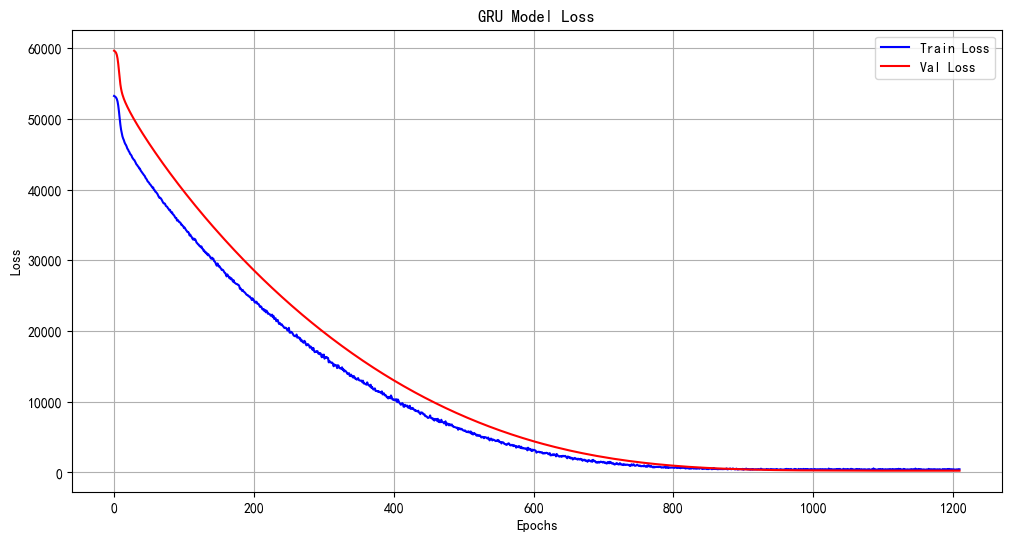

In [45]:
import matplotlib.pyplot as plt
# 绘制train loss和val loss变化
plt.figure(figsize=(12, 6))
plt.plot(gru_history.history['loss'], label='Train Loss', color='blue')
plt.plot(gru_history.history['val_loss'], label='Val Loss', color='red')
plt.title('GRU Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

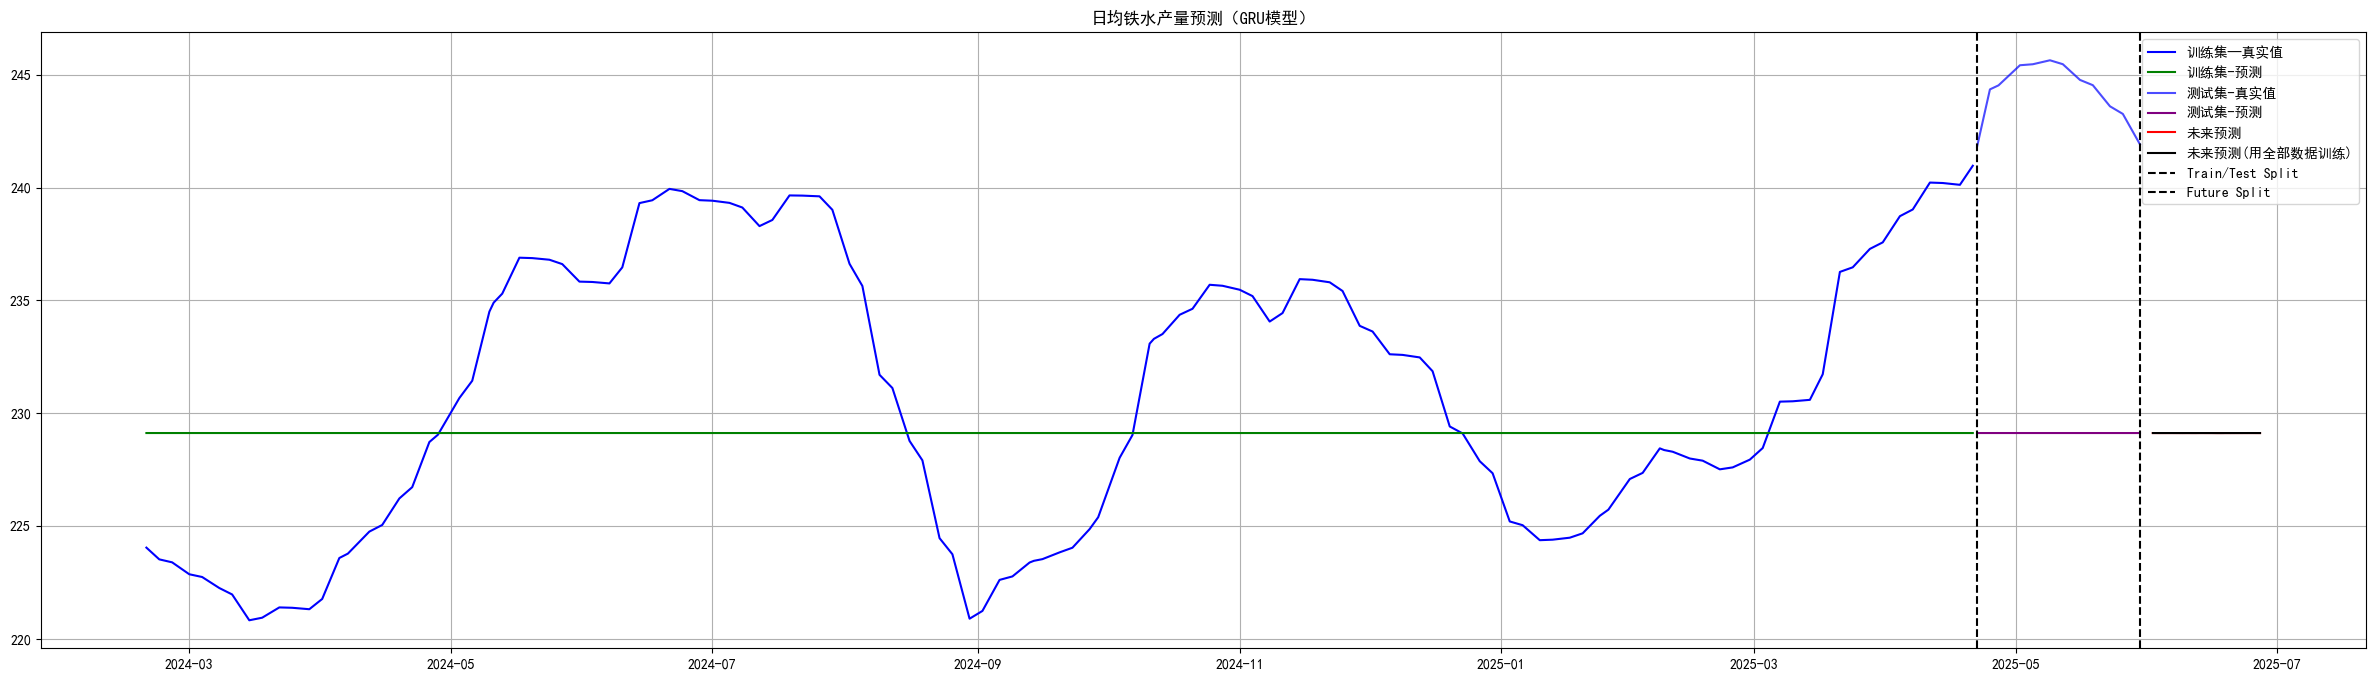

In [46]:
import matplotlib.pyplot as plt

# 设置图表大小
plt.figure(figsize=(30, 8))

# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('日均铁水产量预测（GRU模型）')
plt.legend()
plt.grid(True)

# 展示图表
plt.show()
